# Notebook to compare predictions from different formation channels


In [169]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py

# Use latex for text rendering
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rcParams['text.latex.preamble'] = r'\usepackage{amsmath}'


import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning) #ignore divide by zero warnings

### Load the data 

First the results from this work

Next results from different papers, extracted using WebPlotDigitizer, 

including: 
- Globular cluster results [Antonini et al 2023](https://ui.adsabs.harvard.edu/abs/2023MNRAS.522..466A)
- POP III star results []()


In [228]:
##########################################
# Results from this work:
# marginals inferred from the LIGO/Virgo data (= observed)
# M1 data
observed_m1 = h5py.File('../data/Marginal_m1.h5', 'r')
observed_m1_cutMc = h5py.File('../data/Marginal_m1_cutMc.h5', 'r')

# q distribution
observed_q = h5py.File('../data/marginal_q_data.h5', 'r')
observed_q_cutMc = h5py.File('../data/marginal_q_data_cutMc.h5', 'r')

# chi_effective distribution
observed_chi_eff = h5py.File('../data/marginal_chieff_data.h5', 'r')
observed_chi_eff_cutMc = h5py.File('../data/marginal_chieff_data_cutMc.h5', 'r')
print(observed_chi_eff_cutMc.keys()) # Note that y-values are m dR/dm


##############
# PPISN: Hendriks et al 2023
Hendriks23 = pd.read_csv('../data/Figures_to_Scrape/Hendriks23_m1.csv', header=1)
Hendriks23 = Hendriks23.rename(columns={ 'X': 'M1', 'Y': 'dR_dm'})

##############
# Globular clusters: Antonini et al 2023
Antonini23 = pd.read_csv('../data/Figures_to_Scrape/Antonini23.csv', header=1)
# display(Antonini23)

antonini23_excl_hierarchical = Antonini23[['M1','logdR_dm','q','logdR_dq']]
antonini23_incl_hierarchical = Antonini23[['M1.1','logdR_dm.1','q.1','logdR_dq.1']]

##############
# POP III stars: Kinugawa et al 2021
# M1 masses
Kinugawa21_m1 = pd.read_csv('../data/Figures_to_Scrape/Kinugawa21_m1.csv', header=1)
Kinugawa21_m1 = Kinugawa21_m1.rename(columns={ 'X': 'M1', 'Y': 'dR_dm'})

# Chieff
Kinugawa21_chi_eff = pd.read_csv('../data/Figures_to_Scrape/Kinugawa21_chieff.csv', header=1)
Kinugawa21_chi_eff = Kinugawa21_chi_eff.rename(columns={'X': 'chi_eff', 'Y': 'dD_dchi_eff'})


##############
# Stable mass transfer & CHE
# M1 masses
StableCHE_m1 = pd.read_csv('../data/Figures_to_Scrape/Briel_2023.csv', header=1)
display(StableCHE_m1)


<KeysViewHDF5 ['chi_eff', 'y10', 'y50', 'y90']>


,X,Y,X.1,Y.1
0,2.377345,0.000689,0.038316,0.107104
1,2.664360,0.066067,0.062347,0.898259
2,2.991900,0.151887,0.087912,1.895776
3,3.353110,0.109690,0.112454,5.349613
4,3.772728,0.103035,0.138018,9.563618
5,4.228206,0.197556,0.162561,5.349613
6,4.747996,0.282250,0.187103,6.651733
7,5.331686,0.459901,0.211645,12.015449
8,5.987131,0.480499,0.237721,13.608312
9,6.709953,0.471560,0.262774,8.532245


## Primary mass comparison

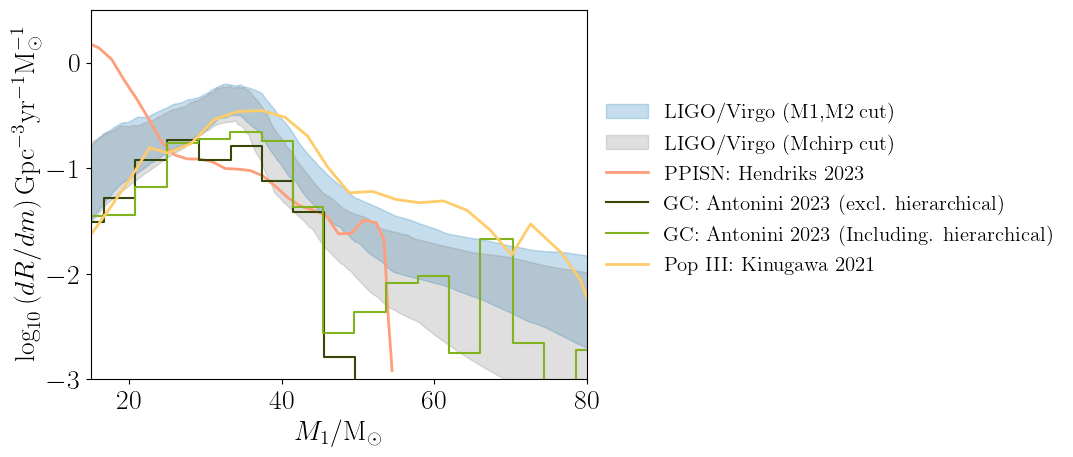

In [171]:
###########
# GW data (observed)
# plt.plot(observed_m1['m1'][()], np.log10(observed_m1['y50'][()]/observed_m1['m1'][()]),
        #  label='LIGO/Virgo (M1,M2 cut)', color='#1A7BB7', lw=3)
plt.fill_between( observed_m1['m1'][()], 
                np.log10(observed_m1['y10'][()]/observed_m1['m1'][()]), 
                np.log10(observed_m1['y90'][()]/observed_m1['m1'][()]),
                alpha=0.25, color='#1A7BB7', label='LIGO/Virgo (M1,M2 cut)')
# with Mchirp cut
# plt.plot(observed_m1_cutMc['m1'][()], np.log10(observed_m1_cutMc['y50'][()]/observed_m1_cutMc['m1'][()]),
        #  label='LIGO/Virgo (Mchirp cut)', color='grey', lw=3)
plt.fill_between( observed_m1_cutMc['m1'][()], 
                np.log10(observed_m1_cutMc['y10'][()]/observed_m1_cutMc['m1'][()]), 
                np.log10(observed_m1_cutMc['y90'][()]/observed_m1_cutMc['m1'][()]),
                alpha=0.25, color='grey', label='LIGO/Virgo (Mchirp cut)')

###########
# PPISN
plt.plot(Hendriks23['M1'], np.log10(Hendriks23['dR_dm']),
         label='PPISN: Hendriks 2023', color='#FF9E7B', lw=2)

###########
# Globular cluster predictions
plt.step(antonini23_excl_hierarchical['M1'], antonini23_excl_hierarchical['logdR_dm'], 
            where = 'mid', label='GC: Antonini 2023 (excl. hierarchical)', color='#374709')

plt.step(antonini23_incl_hierarchical['M1.1'], antonini23_incl_hierarchical['logdR_dm.1'],
         where = 'mid', label='GC: Antonini 2023 (Including. hierarchical)', color='#82b21e')


###########
# POP III predictions
plt.plot(Kinugawa21_m1['M1'], np.log10(Kinugawa21_m1['dR_dm']), 
         label='Pop III: Kinugawa 2021', color='#FECC6A', lw=2)



###########
# plot values
plt.legend(fontsize=15, bbox_to_anchor=(1, 0.8), loc='upper left', frameon=False) 

plt.xlabel(r'$M_1$/M$_\odot$', fontsize=20)
plt.ylabel(r'$\log_{10} \left(d R/dm \right) \mathrm{Gpc^{-3}yr^{-1} M_{\odot}^{-1} }$', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlim(15,80)
plt.ylim(-3, 0.5)

plt.savefig('../figures/Compare_m1_formation.pdf', bbox_inches='tight', dpi=300)
plt.show()

## Mass ratio comparison

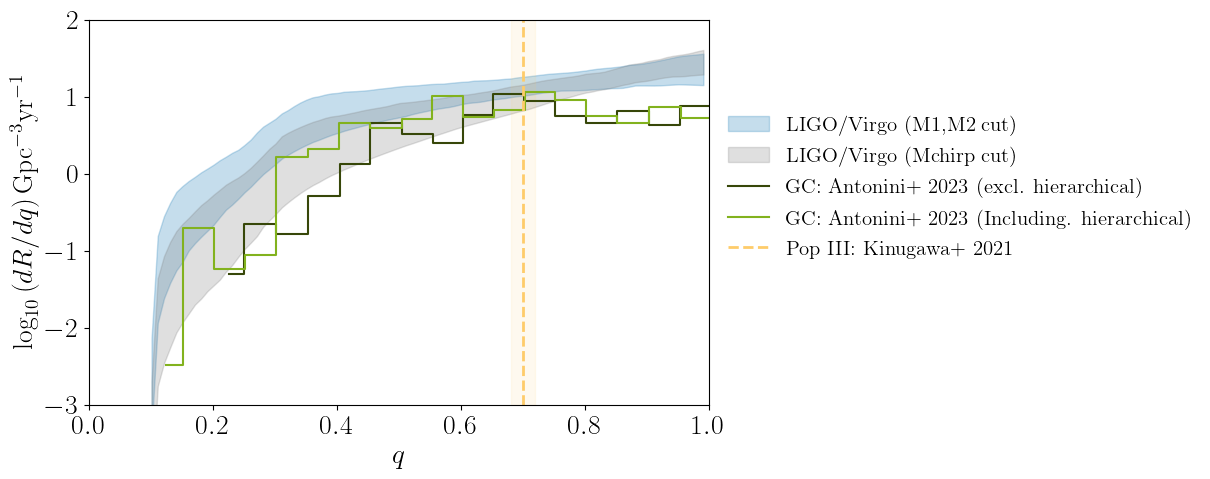

In [227]:
fig, ax = plt.subplots(figsize=(8, 5))

###########
# GW data (observed)
# plt.plot(observed_q['q'][()], np.log10(observed_q['y50'][()]),
        #  label='LIGO/Virgo (M1,M2 cut)', color='#1A7BB7', lw=3, alpha = 0.9)
plt.fill_between(observed_q['q'][()], 
                np.log10(observed_q['y10'][()]), 
                np.log10(observed_q['y90'][()]),
                alpha=0.25, color='#1A7BB7', label='LIGO/Virgo (M1,M2 cut)')
# with Mchirp cut
# plt.plot(observed_q_cutMc['q'][()], np.log10(observed_q_cutMc['y50'][()]),
        #  label='LIGO/Virgo (Mchirp cut)', color='grey', lw=3, alpha = 0.9)
plt.fill_between(observed_q_cutMc['q'][()], 
                np.log10(observed_q_cutMc['y10'][()]), 
                np.log10(observed_q_cutMc['y90'][()]),
                alpha=0.25, color='grey', label='LIGO/Virgo (Mchirp cut)')


###########
# Globular cluster predictions            
x, y = antonini23_excl_hierarchical['q'].dropna(), antonini23_excl_hierarchical['logdR_dq'].dropna() # drop nans
x, y = np.insert(x, len(x), 1.), np.insert(y, len(y), y.iloc[-1])  # repeat value at the end
plt.step(x, y,
            where = 'mid', label='GC: Antonini+ 2023 (excl. hierarchical)', color='#374709')

x1, y1 = antonini23_incl_hierarchical['q.1'].dropna(), antonini23_incl_hierarchical['logdR_dq.1'].dropna() # drop nans
x1, y1 = np.insert(x1, len(x1), 1.), np.insert(y1, len(y1), y1.iloc[-1])  # repeat value at the end
plt.step(x1, y1,
         where = 'mid', label='GC: Antonini+ 2023 (Including. hierarchical)', color='#82b21e')

###########
# POP III predictions Kinugawa et al 2021,
# Their fig. 4 shows all systems around M1, M2 = 30, have q ~ 0.7 
ax.vlines(x=0.7, ymin=-3, ymax=3, color='#FECC6A', lw=2, ls='--', label='Pop III: Kinugawa+ 2021')
plt.fill_between(x=(0.68,0.72), y1=-3, y2=3, color='#FECC6A', alpha=0.1)

###########
# plot values
plt.legend(fontsize=15, bbox_to_anchor=(1, 0.8), loc='upper left', frameon=False) 

plt.xlabel(r'$q$', fontsize=20)
plt.ylabel(r'$\log_{10} \left(d R/dq \right) \mathrm{Gpc^{-3}yr^{-1}}$', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlim(0,1)
plt.ylim(-3, 2)

plt.savefig('../figures/Compare_q_formation.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Spins ($\chi_{eff}$)

Because there are no clear simulated predictions in the literature, we resort to analytical expectations

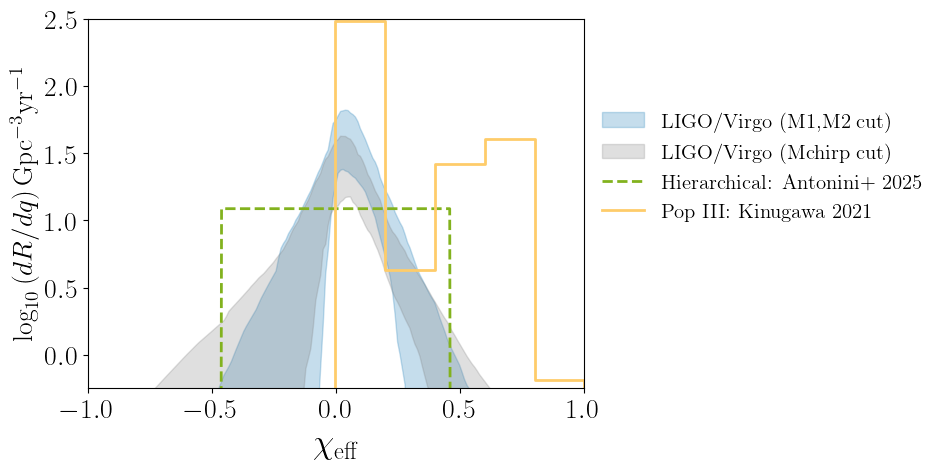

In [ ]:
###########
# GW data (observed)
# plt.plot(observed_chi_eff['chi_eff'][()], np.log10(observed_chi_eff['y50'][()]),
        #  label='LIGO/Virgo (M1,M2 cut)', color='#1A7BB7', lw=2)
plt.fill_between(observed_chi_eff['chi_eff'][()], 
                np.log10(observed_chi_eff['y10'][()]), 
                np.log10(observed_chi_eff['y90'][()]),
                alpha=0.25, color='#1A7BB7', label='LIGO/Virgo (M1,M2 cut)')
# with Mchirp cut
# plt.plot(observed_chi_eff_cutMc['chi_eff'][()], np.log10(observed_chi_eff_cutMc['y50'][()]),
        #  label='LIGO/Virgo (Mchirp cut)', color='grey', lw=2)
plt.fill_between(observed_chi_eff_cutMc['chi_eff'][()], 
                np.log10(observed_chi_eff_cutMc['y10'][()]), 
                np.log10(observed_chi_eff_cutMc['y90'][()]),
                alpha=0.25, color='grey', label='LIGO/Virgo (Mchirp cut)')


###########
# Globular cluster predictions            #
# Analytical model from Antonini 2025 (https://ui.adsabs.harvard.edu/abs/2025PhRvL.134a1401A)
# Their equation 1 
x_chieff = np.linspace(-0.69/1.5, 0.69/1.5, 100)
y_chieff = np.full(len(x_chieff), 0.75/0.69)

# prepend and postpend small values to make it a step function
x_chieff, y_chieff = np.insert(x_chieff, 0, -0.70/1.5), np.insert(y_chieff, 0, -5)
x_chieff, y_chieff = np.insert(x_chieff, len(x_chieff), 0.70/1.5), np.insert(y_chieff, len(y_chieff), -5)

plt.plot(x_chieff, y_chieff, ls = '--', color = '#82b21e', lw=2, label='Hierarchical: Antonini+ 2025')

###########
# Kinugawa 2021
# insert very small value at beginning  to complete the step function
x, y = np.insert(Kinugawa21_chi_eff['chi_eff'], 0, -0.1), np.insert(np.log10(Kinugawa21_chi_eff['dD_dchi_eff']), 0, -5)  
x, y = np.insert(x, len(x), 1.1), np.insert(y, len(y), -5)  # insert very small value at end
plt.step(x,y, where = 'mid', label='Pop III: Kinugawa 2021', color='#FECC6A', lw=2)


###########
# plot values
# plt.vlines(x=0, ymin=-3, ymax=3, color='grey', lw=1, ls='--', zorder = 10)

plt.legend(fontsize=15, bbox_to_anchor=(1, 0.8), loc='upper left', frameon=False) 

plt.xlabel(r'$\chi_{\mathrm{eff}}$', fontsize=25)
plt.ylabel(r'$\log_{10} \left(d R/dq \right) \mathrm{Gpc^{-3}yr^{-1}}$', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=20)

plt.xlim(-1,1)
plt.ylim(-0.25, 2.5)

plt.savefig('../figures/Compare_chi_eff_formation.pdf', bbox_inches='tight', dpi=300)
plt.show()

# Now combine all three figures into one


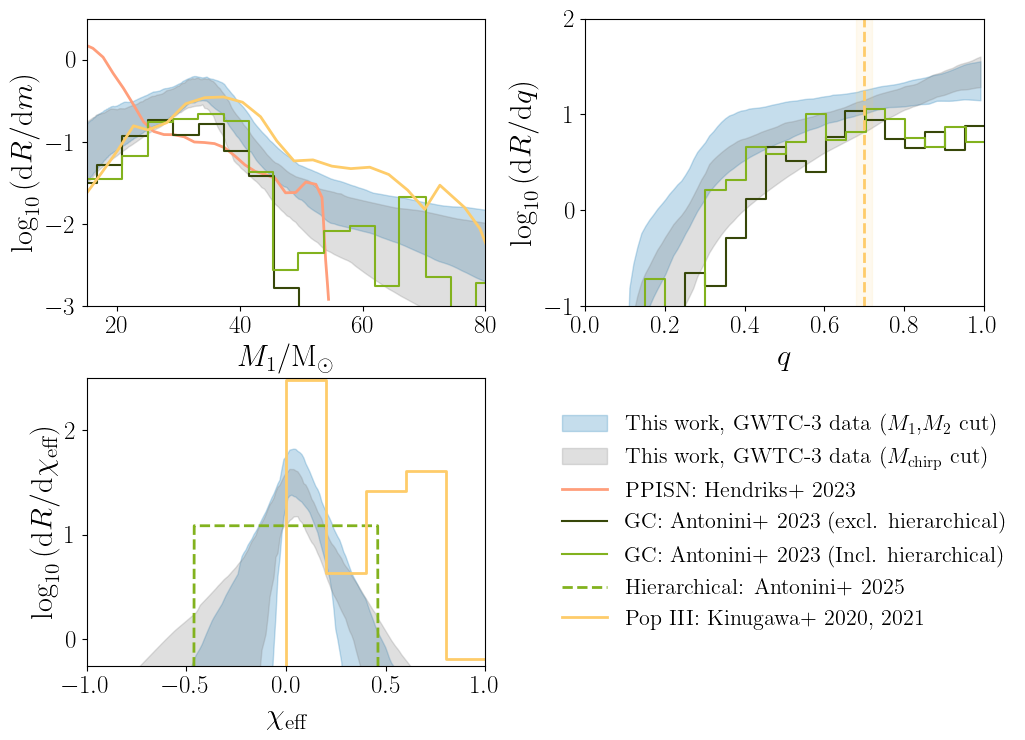

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(10.5, 7.5))

#######################
# Top Left: Mass Plot #
#######################
# GW data (observed)
ax[0, 0].fill_between(observed_m1['m1'][()], 
                     np.log10(observed_m1['y10'][()]/observed_m1['m1'][()]), 
                     np.log10(observed_m1['y90'][()]/observed_m1['m1'][()]),
                     alpha=0.25, color='#1A7BB7', label='This work, GWTC-3 data ($M_1$,$M_2$ cut)')
ax[0, 0].fill_between(observed_m1_cutMc['m1'][()], 
                     np.log10(observed_m1_cutMc['y10'][()]/observed_m1_cutMc['m1'][()]), 
                     np.log10(observed_m1_cutMc['y90'][()]/observed_m1_cutMc['m1'][()]),
                     alpha=0.25, color='grey', label='This work, GWTC-3 data ($M_{\mathrm{chirp}}$ cut)')

# PPISN
ax[0, 0].plot(Hendriks23['M1'], np.log10(Hendriks23['dR_dm']),
             label='PPISN: Hendriks+ 2023', color='#FF9E7B', lw=2)

# Globular clusters
ax[0, 0].step(antonini23_excl_hierarchical['M1'], antonini23_excl_hierarchical['logdR_dm'], 
             where='mid', label='GC: Antonini+ 2023 (excl. hierarchical)', color='#374709')
ax[0, 0].step(antonini23_incl_hierarchical['M1.1'], antonini23_incl_hierarchical['logdR_dm.1'],
             where='mid', label='GC: Antonini+ 2023 (Incl. hierarchical)', color='#82b21e')

# Repeating hierarchical prediction for legend purposes
ax[0, 0].plot((-1,-1), (-1,-1), ls='--', color='#82b21e', lw=2, label='Hierarchical: Antonini+ 2025')

# Pop III
ax[0, 0].plot(Kinugawa21_m1['M1'], np.log10(Kinugawa21_m1['dR_dm']), 
             label='Pop III: Kinugawa+ 2020, 2021', color='#FECC6A', lw=2)

# Axis styling
ax[0, 0].set_xlabel(r'$M_1$/M$_\odot$', fontsize=22)
ax[0, 0].set_ylabel(r'$\log_{10} \left(\mathrm{d}R/\mathrm{d}m \right)$', fontsize=22)
ax[0, 0].tick_params(axis='both', which='major', labelsize=18)
ax[0, 0].set_xlim(15, 80)
ax[0, 0].set_ylim(-3, 0.5)


###########################
# Top Right: Mass Ratio q #
###########################
# GW data (observed)
ax[0, 1].fill_between(observed_q['q'][()], 
                     np.log10(observed_q['y10'][()]), 
                     np.log10(observed_q['y90'][()]),
                     alpha=0.25, color='#1A7BB7', label='LIGO/Virgo (M1,M2 cut)')
ax[0, 1].fill_between(observed_q_cutMc['q'][()], 
                     np.log10(observed_q_cutMc['y10'][()]), 
                     np.log10(observed_q_cutMc['y90'][()]),
                     alpha=0.25, color='grey', label='LIGO/Virgo (Mchirp cut)')

# Globular clusters
x, y = antonini23_excl_hierarchical['q'].dropna(), antonini23_excl_hierarchical['logdR_dq'].dropna() # drop nans
x, y = np.insert(x, len(x), 1.), np.insert(y, len(y), y.iloc[-1])  # repeat value at the end
ax[0, 1].step(x,y,
             where='mid', label='GC: Antonini+ 2023 (excl. hierarchical)', color='#374709')
             
x1, y1 = antonini23_incl_hierarchical['q.1'].dropna(), antonini23_incl_hierarchical['logdR_dq.1'].dropna() # drop nans
x1, y1 = np.insert(x1, len(x1), 1.), np.insert(y1, len(y1), y1.iloc[-1])  # repeat value at the end
ax[0, 1].step(x1, y1,
             where='mid', label='GC: Antonini+ 2023 (Incl. hierarchical)', color='#82b21e')

# Pop III
ax[0, 1].vlines(x=0.7, ymin=-3, ymax=3, color='#FECC6A', lw=2, ls='--', label='Pop III: Kinugawa+ 2021')
ax[0, 1].fill_between(x=(0.68, 0.72), y1=-3, y2=3, color='#FECC6A', alpha=0.1)

# Axis styling
ax[0, 1].set_xlabel(r'$q$', fontsize=22)
ax[0, 1].set_ylabel(r'$\log_{10} \left(\mathrm{d}R/\mathrm{d}q \right)$', fontsize=22)
ax[0, 1].tick_params(axis='both', which='major', labelsize=18)
ax[0, 1].set_xlim(0, 1)
ax[0, 1].set_ylim(-1, 2)


##############################
# Bottom Left: chi_eff Plot  #
##############################
# GW data (observed)
ax[1, 0].fill_between(observed_chi_eff['chi_eff'][()], 
                     np.log10(observed_chi_eff['y10'][()]), 
                     np.log10(observed_chi_eff['y90'][()]),
                     alpha=0.25, color='#1A7BB7', label='LIGO/Virgo (M1,M2 cut)')
ax[1, 0].fill_between(observed_chi_eff_cutMc['chi_eff'][()], 
                     np.log10(observed_chi_eff_cutMc['y10'][()]), 
                     np.log10(observed_chi_eff_cutMc['y90'][()]),
                     alpha=0.25, color='grey', label='LIGO/Virgo (Mchirp cut)')

# Hierarchical prediction
x_chieff = np.linspace(-0.69/1.5, 0.69/1.5, 100)
y_chieff = np.full(len(x_chieff), 0.75/0.69)
x_chieff, y_chieff = np.insert(x_chieff, 0, -0.70/1.5), np.insert(y_chieff, 0, -5)
x_chieff, y_chieff = np.insert(x_chieff, len(x_chieff), 0.70/1.5), np.insert(y_chieff, len(y_chieff), -5)
ax[1, 0].plot(x_chieff, y_chieff, ls='--', color='#82b21e', lw=2, label='Hierarchical: Antonini+ 2025')

# Pop III
x, y = np.insert(Kinugawa21_chi_eff['chi_eff'], 0, -0.1), np.insert(np.log10(Kinugawa21_chi_eff['dD_dchi_eff']), 0, -5)
x, y = np.insert(x, len(x), 1.1), np.insert(y, len(y), -5)
ax[1, 0].step(x, y, where='mid', label='Pop III: Kinugawa 2020, 2021', color='#FECC6A', lw=2)

# Axis styling
ax[1, 0].set_xlabel(r'$\chi_{\mathrm{eff}}$', fontsize=22)
ax[1, 0].set_ylabel(r'$\log_{10} \left(\mathrm{d}R/\mathrm{d}\chi_{\mathrm{eff}} \right)$', fontsize=22)
ax[1, 0].tick_params(axis='both', which='major', labelsize=18)
ax[1, 0].set_xlim(-1, 1)
ax[1, 0].set_ylim(-0.25, 2.5)


##########################
# Bottom Right: Legend   #
##########################
ax[1, 1].axis('off')  # Turn off the axis
handles, labels = ax[0, 0].get_legend_handles_labels()
ax[1, 1].legend(handles, labels, loc='center', fontsize=16, frameon=False)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(wspace=0.25, hspace=0.25)

# Save the combined figure
plt.savefig('../figures/Compare_formation_combined.pdf', bbox_inches='tight', dpi=300)
plt.show()
